In [2]:
import pecos as pc
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import math
from scipy.special import factorial, erfinv # vectorized factorial function

In [5]:
circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})
n_gates = len(ghz)

two_qb_gates = ['CNOT']
one_qb_gates = ['measure Z', 'H']
one_qb_errs = ['X','Y','Z']
two_qb_errs  = list(it.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
two_qb_errs.remove(('I','I')) # remove II as it is not a fault

def var(p,n):
    return p * (1-p) / n

def mean(k,n):
    return k / n

def ERV(counts, fail_counts):
    p = mean(fail_counts, counts)
    v = var(p, counts)
    
    p_p = mean(fail_counts+1, counts+1)
    p_m = mean(fail_counts, counts+1)
    v_p = var(p_p, counts+1)
    v_m = var(p_m, counts+1)
    
    v_prop = p*v_p + (1-p)*v_m
    delta = v - v_prop
    
    return np.argmax(delta)
    
def logical_failure_rate_SS(ref_circuit, w_max, p_phys, n_samples):

    # generate subset failure rates
    # subset_failure_rates = np.array([0] + [subset_failure_rate(ref_circuit, w, n_samples) for w in range(1,w_max+1)])
    
    w_min = 1 # ignore 0-fault subset only.
    counts = np.zeros((w_max+1-w_min), dtype=int) + 10
    fail_counts = np.zeros((w_max+1-w_min), dtype=int) + 5
    
    for _ in range(n_samples):

        # 1. Generate a subset circuit, place random faults at w gates
        subset_circuit = ref_circuit.copy()
        subset_weight = ERV(counts, fail_counts) + w_min
        
        fault_locs = np.random.choice(len(subset_circuit), subset_weight, replace=False)
        offset = 0
        for loc in fault_locs:
            for sym, qbs, params in subset_circuit[loc].items():
                if sym in two_qb_gates: 
                    faults = two_qb_errs[np.random.choice(len(two_qb_errs))]
                    for fault, qb in zip(faults, list(*qbs)):
                        if fault != "I": 
                            subset_circuit.insert(loc+offset, ({fault: {qb}}, {}))
                            offset += 1
                elif sym in one_qb_gates: 
                    fault = np.random.choice(one_qb_errs)
                    subset_circuit.insert(loc+offset, ({fault: qbs}, {}))
                    offset += 1

        # 2. Simuluate a circuit run with |00..0> and measure in Z
        sim = pc.simulators.SparseSim(5)
        msmt, _ = circ_runner.run(sim, subset_circuit)

        # 3.Count logical failures
        counts[subset_weight - w_min] += 1
        if msmt: fail_counts[subset_weight - w_min] += 1

    subset_failure_rates = np.zeros((w_max+1)) # ignore 0-weight subset
    subset_failure_rates[w_min:] = fail_counts / counts
    
    # Binomial weight: Tot. probability of sampling weight-w circuits from all possible circuits
    A_w = lambda p,w,N: math.comb(N,w) * p**(w) * (1-p)**(N-w)
    A = np.array([[A_w(p_phy,w,n_gates) for p_phy in p_phys] for w in range(w_max+1)])
    
    # Overall bounded logical failure rates
    p_L_low = np.sum(A * subset_failure_rates[:,None], axis=0)
    p_L_up = p_L_low + 1 - np.sum(A, axis=0)

    # Subset and overall standard deviations
    e_SS_w = lambda p, n: np.sqrt( (p * (1-p)) / n )
    e_SS = np.sqrt( np.sum((A[1:] * e_SS_w(subset_failure_rates[1:,None], n_samples))**2, axis=0) )
    return p_L_low, p_L_up, e_SS

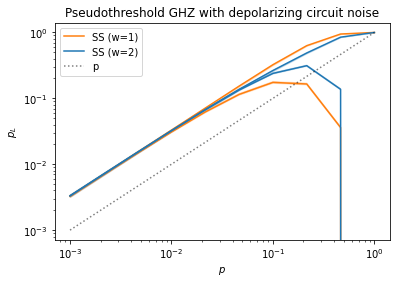

CPU times: user 749 ms, sys: 126 ms, total: 875 ms
Wall time: 662 ms


In [6]:
%%time

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$p_L$')
plt.title('Pseudothreshold GHZ with depolarizing circuit noise')

n_samples = 1000 # number of samples per subset
p_phy = np.logspace(-3, 0, 10) # physical error rates

# Plot SS
for col, w_m in zip(['tab:orange', 'tab:blue'],[1,2]):
    p_L_low, p_L_up, e_SS = logical_failure_rate_SS(ghz,w_m,p_phy,n_samples)
    plt.plot(p_phy, p_L_low, c=col, label="SS (w=%s)"%w_m)
    plt.fill_between(p_phy, p_L_low-e_SS, p_L_low+e_SS, color=col, alpha=0.2)
    plt.plot(p_phy, p_L_up, c=col)
    plt.fill_between(p_phy, p_L_up-e_SS, p_L_up+e_SS, color=col, alpha=0.2)
    
plt.plot(p_phy, p_phy, 'k:', alpha=0.5, label="p")
plt.legend()
plt.show()

## Include ERV in OOP SS sampler

[ 67 145 145 144  67 144 144 144] [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]
CPU times: user 239 ms, sys: 10.7 ms, total: 249 ms
Wall time: 218 ms


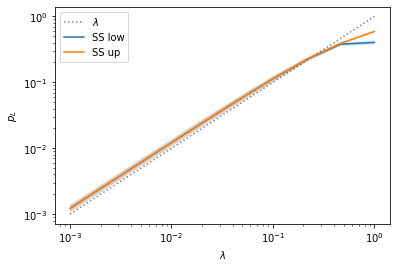

In [32]:
%%time
circ_runner = pc.circuit_runners.Standard(seed=np.random.randint(1e9))

ghz = pc.circuits.QuantumCircuit()
ghz.append('H', {0})
ghz.append('CNOT', {(0,1)})
ghz.append('CNOT', {(1,2)})
ghz.append('CNOT', {(2,3)})
ghz.append('CNOT', {(3,4)})
ghz.append('CNOT', {(0,4)})
ghz.append('measure Z', {4})

### Analytics
z = 1.96 # 95% constant confidence interval
Wilson_max = lambda p,N: (p + z**2/(2*N) + z*np.sqrt(p*(1-p)/N+z**2/(4*N**2)))/(1+z**2/N)
Wilson_min = lambda p,N: (p + z**2/(2*N) - z*np.sqrt(p*(1-p)/N+z**2/(4*N**2)))/(1+z**2/N)

Wilson_std = lambda p,N: Wilson_max(p,N) - Wilson_min(p,N)
Wald_std = lambda p,N: np.sqrt(p * (1-p) / N)

rssp = lambda a,e: np.sqrt(np.sum( (a*e)**2, axis=0 )) # root sum of squared products
stdev = lambda A,p,N, std_type: rssp(A[1:], (Wilson_std if std_type=='Wilson' else Wald_std)(p[1:], N))

nCr = lambda n,r: factorial(n) / (factorial(r)*factorial(n-r)) # Vectorized combination
A_w = lambda n,w,p: nCr(n,w) * p**w * (1-p)**(n-w) # (Binomial) subset probability

### Numerics
def run_circuit(state, circuit, err_circuit=None):
    out = []
    for tick_circuit, tick, _ in circuit.iter_ticks():
        res = state.run_circuit(tick_circuit)
        if res: out.append(res)
        if err_circuit: # All faults are treated as "after" faults here
            state.run_circuit(err_circuit[tick])
    return out
    
class DepolarGen(): # depolar error generator for circuit level noise
    one_qb_errs = ['X','Y','Z']
    two_qb_errs  = list(it.product(one_qb_errs + ["I"], repeat=2)) # variation with repetition
    two_qb_errs.remove(('I','I')) # remove II as it is not a fault
    
    def __init__(self, choose_fn, n_ticks):
        self.choose_fn = choose_fn # Naive and Subset sampler error generators differ only by the choose function.
        self.n_ticks = n_ticks
    
    def generate(self, partitions, values):
        err_circ = pc.circuits.QuantumCircuit(self.n_ticks)
        for errs in [self.choose_fn(p,v) for p, v in zip(partitions, values)]: ## WORK WITH DICT AND ADD SELECTION OF ERROR SETS
            for (tick, qbs) in errs:
                if type(qbs) == int:
                    err_circ.update(np.random.choice(self.one_qb_errs), tick=tick, locations={qbs})
                elif type(qbs) == tuple:
                    for (fault, qb) in zip(self.two_qb_errs[np.random.choice(len(self.two_qb_errs))], qbs):
                        if fault != "I":
                            err_circ.update(fault, tick=tick, locations={qb})
        return err_circ
    
class Sampler():
    
    one_qb_gates = {'H'}
    two_qb_gates = {'CNOT'}
    
    def __init__(self, circuit, err_params):
        self.circuit = circuit
        self.n_qbs = len(circuit.qudits)   
        self.partitions = self._partition_circuit(circuit, err_params.keys())
        self.partition_probabilities = self._partition_probability_matrix(err_params.values())
        self.partition_lens = np.array([len(p) for p in self.partitions])
    
    def _partition_circuit(self, circuit, keys):
        # select collection of lists of (tick, qb) tuples representing elements in a circuit partition (i.e. "gate group")
        partitions = {
            "p": [(i, qb) for i, (sym, qbs, _) in enumerate(circuit.items()) for qb in qbs],
            "p1": [(i, qb) for i, (sym, qbs, _) in enumerate(circuit.items()) for qb in qbs if sym in self.one_qb_gates],
            "p2": [(i, qb) for i, (sym, qbs, _) in enumerate(circuit.items()) for qb in qbs if sym in self.two_qb_gates],
            "p_idle1": [(i, qb) for i in range(len(circuit)) for qb in circuit.qudits.difference(circuit.active_qudits[i]) if list(circuit[i].symbols.keys())[0] in self.one_qb_gates],
            'p_idle2': [(i, qb) for i in range(len(circuit)) for qb in circuit.qudits.difference(circuit.active_qudits[i]) if list(circuit[i].symbols.keys())[0] in self.two_qb_gates],
            "p_init": [(i, qb) for i, (sym, qbs, _) in enumerate(circuit.items()) for qb in qbs if "init" in sym],
            "p_meas": [(i, qb) for i, (sym, qbs, _) in enumerate(circuit.items()) for qb in qbs if "measure" in sym],
            "p_xtalk1": [(i, tuple(qb)[0]+j) for i, qb in enumerate(circuit.active_qudits) for j in [-1, +1] if tuple(qb)[0]+j in circuit.qudits and list(circuit[i].symbols.keys())[0] in self.one_qb_gates],
            "p_xtalk2": [(i, tuple(qb)[-1]+j) for i, qb in enumerate(circuit.active_qudits) for j in [-1, +1] if tuple(qb)[-1]+j in circuit.qudits and list(circuit[i].symbols.keys())[0] in self.two_qb_gates]
        }
        return [partitions[k] for k in keys]
    
    def _partition_probability_matrix(self, vals):
        # generate matrix P of dims (scaling range) x (specified partitions)
        n_partitions = len(vals)
        n_points = max([len(v) if type(v) == np.ndarray else 1 for v in vals])
        P = np.zeros((n_points, n_partitions))
        for i, v in enumerate(vals): 
            P[:,i] = v
        return P
    
class SubsetSampler(Sampler):
    
    def __init__(self, circuit, err_params):
        super().__init__(circuit, err_params)
        choose_fn = lambda l,k: [l[i] for i in np.random.choice(len(l),k,replace=False)]
        self.err_gen = DepolarGen(choose_fn=choose_fn, n_ticks=len(circuit))
            
    def _min_weight(self, p_max, d_max, w_max):
        delta = 1
        for w in range(w_max+1):
            delta -= A_w(w_max, w, p_max)
            if delta < d_max: break
        return w
    
    def _ERV(self, counts, fail_counts):
        n_counts = counts + 1
        n_fail_counts = fail_counts + 1

        p = fail_counts / counts
        v = p * (1-p) / counts

        p_p = n_fail_counts / n_counts
        p_m = fail_counts / n_counts
        v_p = p_p * (1-p_p) / n_counts
        v_m = p_m * (1-p_m) / n_counts

        v_proposal = p * v_p + (1 - p) * v_m
        delta = v - v_proposal

        return np.argmax(delta)
    
    def _sample(self, n_samples, err_gen, w_combis):
        
        counts = np.zeros((len(w_combis))) + 10 # Assume 10 virtual samples and
        fail_counts = np.zeros((len(w_combis))) + 5 # 5 of them failed (this also includes 0-weight-subset)
        
        choice_hist = [] # for printing: let's look at the choice of weight subsets ERV determined
        for _ in range(n_samples):
            idx = self._ERV(counts, fail_counts)
            choice_vector = w_combis[idx]
            choice_hist.append(idx)
            state = pc.simulators.SparseSim(self.n_qbs)
            err_circuit = err_gen.generate(self.partitions, choice_vector)
            msmt = run_circuit(state, self.circuit, err_circuit)
            counts[idx] += 1
            if msmt: 
                fail_counts[idx] += 1
        print(np.bincount(choice_hist), w_combis) # We see that the two 2-qb gate faults=0 subsets have the least significance (we always get no fault for those, though we sample them due to initial virtual samples)
        return (fail_counts-5) / (counts-10) # Here we remove our initial virtual samples
    
    def run(self, p_max, delta_max, n_samples=20):
        
        # Find w_max vector for delta_max
        assert len(p_max) == len(delta_max) == len(self.partitions)
        w_cutoff = np.zeros_like(p_max, dtype=int)
        for i in range(len(w_cutoff)):
            w_cutoff[i] = self._min_weight(p_max[i], delta_max[i], self.partition_lens[i])
        
        # Generate all weight vector combis from w_max vector
        w_vecs = list(it.product( *[list(range(w_cutoff_i+1)) for w_cutoff_i in w_cutoff] )) # includes the 0,0 subset (which we later ignore)
        
        # Numerical part: Generate 1D list of subset error rates per weight vector combination
        pws = self._sample(n_samples, self.err_gen, w_vecs)[:,None]

        # Analytical part: Calculate 3D tensor of binom. coefs. per weight vector combi, partition & partition probabilities
        As = np.array([A_w(self.partition_lens,w_vec,self.partition_probabilities) for w_vec in w_vecs])
        As = np.product(As, axis=-1) # eliminate last axis by multiplying over it. (Particularly important for multi-p case, for single-p this axis is 1)

        # Calculate statistics
        p_L_low = np.sum(As * pws, axis=0)
        p_L_up = p_L_low + 1 - np.sum(As, axis=0)

        # std = Wilson_stdev(As, pws, n_samples)
        std = stdev(As,pws,n_samples, "Wilson")
                
        return p_L_low, p_L_up, std
    
lambdas = np.logspace(-3, 0, 10) # physical error rates
scale = lambda p_init, lambdas=lambdas: p_init * lambdas
err_params = {'p1': scale(1), 'p2':scale(0.5)}

sss = SubsetSampler(ghz, err_params)
p_L_low, p_L_up, std = sss.run(p_max=[0.5, 0.5], delta_max=[0.1,0.5], n_samples=1000)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$p_L$')
plt.plot(lambdas, lambdas, 'k:', alpha=0.5, label=r"$\lambda$")
plt.plot(lambdas, p_L_low, label="SS low")
plt.fill_between(lambdas, p_L_low-std, p_L_low+std, alpha=0.2)
plt.plot(lambdas, p_L_up, label="SS up")
plt.fill_between(lambdas, p_L_up-std, p_L_up+std, alpha=0.2)
plt.legend()